In [1]:
from Data_Loader import load_data
from Train2 import trainCox_nnet

import torch
import numpy as np
import pandas as pd
from torch.utils.data.dataloader import DataLoader

In [2]:
dtype = torch.FloatTensor
''' Net Settings'''
Hidden_Nodes = 143 ###number of hidden nodes
Out_Nodes = 30 ###number of hidden nodes in the last hidden layer
''' Initialize '''
Initial_Learning_Rate = [0.03, 0.01, 0.001, 0.00075]
L2_Lambda = [0.1, 0.01, 0.005, 0.001]
num_epochs = 3 ###for grid search
Num_EPOCHS = 2 ###for training
###sub-network setup
Dropout_Rate = [0.7, 0.5]

Data preprocessing 

In [3]:
from Data_extraction_lung import data_norm_df_lung, output_df_lung

# print(np.shape(output_df_lung))


In [4]:
print(data_norm_df_lung.shape)

(555, 60660)


In [5]:
data_norm_df_lung= data_norm_df_lung.reset_index(drop=True)
output_df_lung = output_df_lung.reset_index(drop=True)


In [6]:
data = pd.concat([data_norm_df_lung,output_df_lung], axis=1)

def split_indices(n, val_pct1, val_pct2):
	n1 = int(val_pct1*n)
	n2 = int(val_pct2*n)
	idxs = np.random.permutation(n)
	train, val, test = idxs[:n1], idxs[n1:n2], idxs[n2:]
	train.sort(), val.sort(), test.sort()
	return(train, val, test)


# train_index, val_index, test_index = split_indices(len(data),0.6, 0.8)

# data_train = data.iloc[train_index]
# data_val = data.iloc[val_index]
# data_test = data.iloc[test_index]
# x_train, ytime_train, yevent_train, age_train = load_data(data_train, dtype)
# x_valid, ytime_valid, yevent_valid, age_valid = load_data(data_val, dtype)
# x_test, ytime_test, yevent_test, age_test = load_data(data_test,dtype)

PCA

In [7]:
x, ytime, yevent, age = load_data(data, dtype)
# from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(x)
# pca = PCA(.95)
# pca.fit(x)
# x = pca.transform(x)
# x= torch.from_numpy(x)
# print(x.shape)

In [8]:
from Data_Loader import CustomDataset
batch_size=32
data2 = CustomDataset(x, ytime, yevent, age)
In_Nodes = len(x[0,:]) ###number of genes
# train_loader = DataLoader(data2, batch_size, sampler=train_index)
# val_loader = DataLoader(data2, batch_size, sampler=val_index)

In [9]:
opt_l2_loss = 0
opt_lr_loss = 0
opt_do_loss = 0
opt_loss = torch.Tensor([float("Inf")])
###if gpu is being used
if torch.cuda.is_available():
	opt_loss = opt_loss.cuda()
###
opt_c_index_va = 0
opt_c_index_tr = 0

Grid search for the optimal learning rate, regularisation, drop out 

In [10]:
# for l2 in L2_Lambda:
# 	for lr in Initial_Learning_Rate:
# 		for do in Dropout_Rate:
# 			history_train, history_val = trainCox_nnet(data2, \
# 				In_Nodes, Hidden_Nodes, Out_Nodes, \
# 				lr, l2, num_epochs, do, batch_size)
# 			loss_train2 = [k['loss'] for k in history_train[1]]
# 			if loss_train2[-1] =='nan': 
# 				break
# 			elif loss_train2[-1] < opt_loss:
# 				opt_l2_loss = l2
# 				opt_lr_loss = lr
# 				opt_do_loss = do
# 				opt_loss = loss_train2[-1]
# 				# opt_c_index_tr = c_index_tr
# 				# opt_c_index_va = c_index_va
# 			print ("L2: ", l2, "LR: ", lr, "Loss in Validation: ", opt_loss)

In [11]:
opt_l2_loss, opt_lr_loss, opt_do_loss = 0.001, 0.001, 0.5
print(In_Nodes)
#print(opt_l2_loss, opt_lr_loss, opt_do_loss)

60660


Train the model 

In [12]:
###train Cox-nnet with optimal hyperparameters using train data, and then evaluate the trained model with test data
###Note that test data are only used to evaluate the trained Cox-nnet
history_train, history_val = trainCox_nnet(data2, \
			In_Nodes, Hidden_Nodes, Out_Nodes, \
			opt_lr_loss, opt_l2_loss, Num_EPOCHS, opt_do_loss, batch_size)
print ("Optimal L2: ", opt_l2_loss, "Optimal LR: ", opt_lr_loss)
# print("C-index in Test: ", c_index_te)

------------fold no---------0----------------------
Epoch [0], loss: 2.9150, c_index: 0.5859
Epoch [1], loss: 2.5025, c_index: 0.5954
Epoch [2], loss: 2.3743, c_index: 0.5998
------------fold no---------1----------------------
Epoch [0], loss: 3.1415, c_index: 0.5358
Epoch [1], loss: 2.3608, c_index: 0.5262
Epoch [2], loss: 2.3625, c_index: 0.5246
------------fold no---------2----------------------
Epoch [0], loss: 2.4868, c_index: 0.3316
Epoch [1], loss: 2.4348, c_index: 0.6970
Epoch [2], loss: 2.4497, c_index: 0.6985
------------fold no---------3----------------------
Epoch [0], loss: 2.7826, c_index: 0.6567
Epoch [1], loss: 2.3099, c_index: 0.6533
Epoch [2], loss: 2.3622, c_index: 0.6495
------------fold no---------4----------------------
Epoch [0], loss: 3.0086, c_index: 0.5617
Epoch [1], loss: 2.5522, c_index: 0.5635
Epoch [2], loss: 2.3227, c_index: 0.5741
Optimal L2:  0.001 Optimal LR:  0.001


Performances and visualisation 

In [13]:
loss_train_fold0 = [k['loss'] for k in history_train[0]]
loss_val_fold0 = [k['loss'] for k in history_val[0]] 
c_index_train_fold0 = [k['c_index'] for k in history_train[0]]
c_index_val_fold0 = [k['c_index'] for k in history_val[0]]

loss_train_fold1 = [k['loss'] for k in history_train[1]]
loss_val_fold1 = [k['loss'] for k in history_val[1]] 
c_index_train_fold1 = [k['c_index'] for k in history_train[1]]
c_index_val_fold1 = [k['c_index'] for k in history_val[1]]

loss_train_fold2 = [k['loss'] for k in history_train[2]]
loss_val_fold2 = [k['loss'] for k in history_val[2]] 
c_index_train_fold2 = [k['c_index'] for k in history_train[2]]
c_index_val_fold2 = [k['c_index'] for k in history_val[2]]

loss_train_fold3 = [k['loss'] for k in history_train[3]]
loss_val_fold3 = [k['loss'] for k in history_val[3]] 
c_index_train_fold3 = [k['c_index'] for k in history_train[3]]
c_index_val_fold3 = [k['c_index'] for k in history_val[3]]

loss_train_fold4 = [k['loss'] for k in history_train[4]]
loss_val_fold4 = [k['loss'] for k in history_val[4]] 
c_index_train_fold4 = [k['c_index'] for k in history_train[4]]
c_index_val_fold4 = [k['c_index'] for k in history_val[4]]


In [14]:
epoch = np.arange(0,Num_EPOCHS+1)

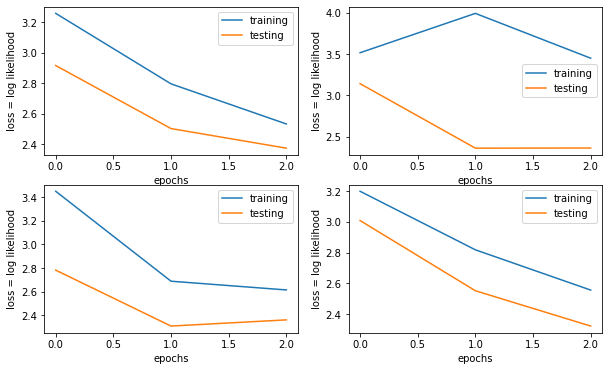

In [15]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,6))
plt.subplot(221)
plt.plot(epoch, loss_train_fold0, label = 'training')
plt.plot(epoch, loss_val_fold0, label = 'testing')
plt.ylabel('loss = log likelihood')
plt.xlabel('epochs')
plt.legend()

plt.subplot(222)
plt.plot(epoch, loss_train_fold1, label = 'training')
plt.plot(epoch, loss_val_fold1, label = 'testing')
plt.ylabel('loss = log likelihood')
plt.xlabel('epochs')
plt.legend()



plt.subplot(223)
plt.plot(epoch, loss_train_fold3, label = 'training')
plt.plot(epoch, loss_val_fold3, label = 'testing')
plt.ylabel('loss = log likelihood')
plt.xlabel('epochs')
plt.legend()

plt.subplot(224)
plt.plot(epoch, loss_train_fold4, label = 'training')
plt.plot(epoch, loss_val_fold4, label = 'testing')
plt.ylabel('loss = log likelihood')
plt.xlabel('epochs')
plt.legend()



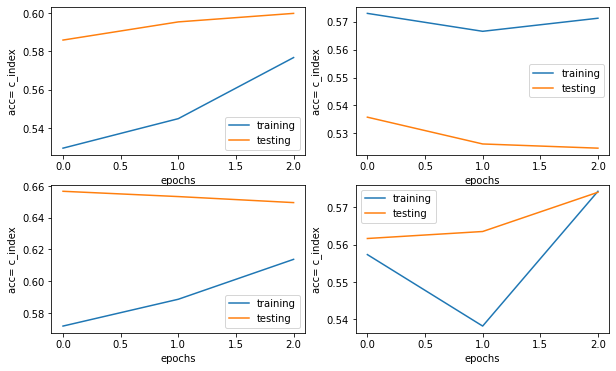

In [16]:
plt.figure(figsize=(10,6))
plt.subplot(221)
plt.plot(epoch, c_index_train_fold0, label = 'training')
plt.plot(epoch, c_index_val_fold0, label = 'testing')
plt.ylabel('acc= c_index')
plt.xlabel('epochs')
plt.legend()

plt.subplot(222)
plt.plot(epoch, c_index_train_fold1, label = 'training')
plt.plot(epoch, c_index_val_fold1, label = 'testing')
plt.ylabel('acc= c_index')
plt.xlabel('epochs')
plt.legend()

plt.subplot(223)
plt.plot(epoch, c_index_train_fold3, label = 'training')
plt.plot(epoch, c_index_val_fold3, label = 'testing')
plt.ylabel('acc= c_index')
plt.xlabel('epochs')
plt.legend()

plt.subplot(224)
plt.plot(epoch, c_index_train_fold4, label = 'training')
plt.plot(epoch, c_index_val_fold4, label = 'testing')
plt.ylabel('acc= c_index')
plt.xlabel('epochs')
plt.legend()


In [34]:
#result cross validation

print(np.mean([c_index_val_fold1[2], c_index_val_fold0[2], c_index_val_fold3[2], c_index_val_fold2[2],c_index_val_fold4[2]]))

0.6093095541000366


In [18]:
#before there was cross validation

# loss_train2 = [k['loss'] for k in history_train]
# loss_val2 = [k['loss'] for k in history_val] 
# c_index_tr2 = [k['c_index'] for k in history_train]
# c_index_val2 = [k['c_index'] for k in history_val]

# loss_train2 = [k.detach().numpy() for k in loss_train]
# loss_test2 = [k.detach().numpy() for k in loss_test]
# c_index_tr2 = [k.detach().numpy() for k in c_index_tr]
# c_index_te2 = [k.detach().numpy() for k in c_index_te]
# epoch = np.arange(0,Num_EPOCHS+2,2)

In [19]:
# from Survival_CostFunc_CIndex import R_set, neg_par_log_likelihood, c_index
# from Model2 import Cox_nnet

# net = Cox_nnet(In_Nodes, Hidden_Nodes, Out_Nodes, 0.5)
# net.eval()
# data_test = data.iloc[test_index]
# x_test, ytime_test, yevent_test, age_test = load_data(data_test,dtype)
# test_pred=net(x_test, age_test)
# eval_loss = []
# eval_cindex=[]
# eval_loss.append(neg_par_log_likelihood(test_pred, ytime_test, yevent_test).view(1,))
# eval_cindex.append(c_index(test_pred, ytime_test, yevent_test))

Data visualisation 

<AxesSubplot:xlabel='vital_status', ylabel='count'>

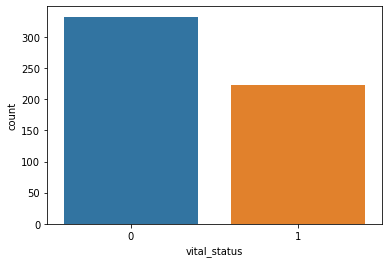

In [20]:
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.countplot(x='vital_status', data=data)

In [ ]:
x_df=pd.DataFrame(x, columns = np.arange(len(x[0,:])))
data_cph = pd.concat([x_df,pd.DataFrame({'age': age[:,0], 'yevent': yevent[:,0], 'ytime': ytime[:,0]})], axis=1)
essai = data_cph.drop(data[data_cph.yevent==0].index)
essai2 = data_cph.drop(data_cph[data_cph.yevent==1].index)

C:\Users\anais\AppData\Local\Temp\ipykernel_6292\2735630853.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  essai = data_cph.drop(data[data_cph.yevent==0].index)


c:\Users\anais\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


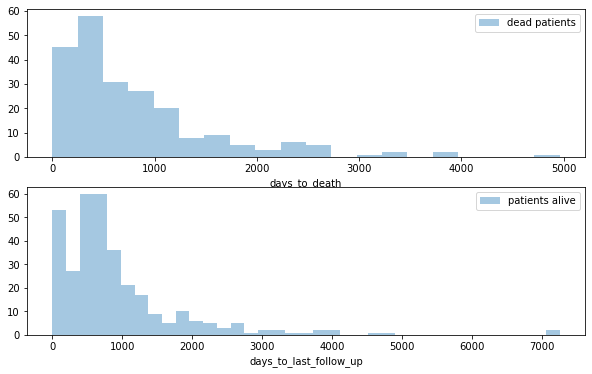

In [ ]:
plt.figure(figsize=(10,6))
plt.subplot(211)
sns.distplot(essai['ytime'], kde=False, label='dead patients')
plt.xlabel('days_to_death')
plt.legend()
plt.subplot(212)
sns.distplot(essai2['ytime'], kde=False, label='patients alive')
plt.xlabel('days_to_last_follow_up')
plt.legend()


c:\Users\anais\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


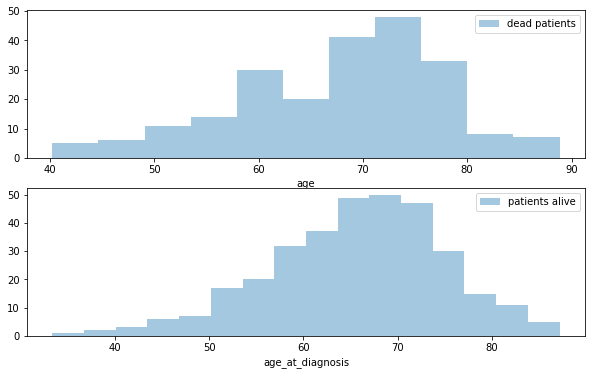

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns 



plt.figure(figsize=(10,6))
plt.subplot(211)
sns.distplot(essai['age']/365, kde=False, label='dead patients')
plt.legend()
plt.subplot(212)
sns.distplot(essai2['age']/365, kde=False, label='patients alive')
plt.xlabel('age_at_diagnosis')
plt.legend()


PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from Data_Loader import sort_data
x, ytime, yevent, age = sort_data(data)
x = StandardScaler().fit_transform(x)
pca = PCA(.98)
pca.fit(x)
x = pca.transform(x)

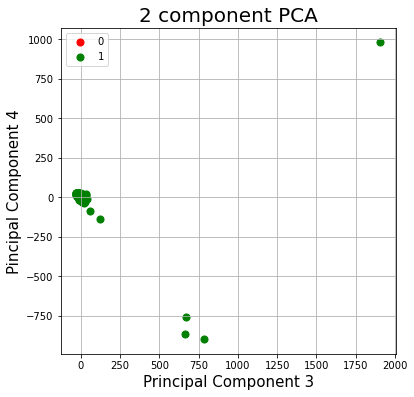

In [ ]:
import matplotlib.pyplot as plt
principalDf = pd.DataFrame(data=x[:,0:2], columns = ['principal component 1', 'principal component 2'])
principalDf['yevent']= yevent
# finalDf = pd.concat([principalDf, yevent2], axis=1)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 3', fontsize = 15)
ax.set_ylabel('Pincipal Component 4', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [0,1]
colors = ['r','g']
for target, color in zip(targets, colors): 
    indicesToKeep = principalDf['yevent']==target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1'], principalDf.loc[indicesToKeep, 'principal component 2'], c = color, s=50)
ax.legend(targets)
ax.grid()


Data visualisation: Kaplan Meier

In [ ]:
from lifelines import KaplanMeierFitter

<AxesSubplot:xlabel='timeline'>

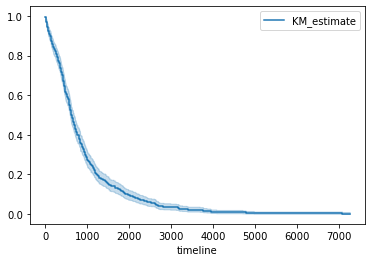

In [ ]:
kmf = KaplanMeierFitter()
kmf.fit(durations = ytime, event_observed = yevent)
kmf.plot_survival_function()

CoxPH Analysis 

In [ ]:
from lifelines import CoxPHFitter
from Data_Loader import sort_data
from sklearn.preprocessing import StandardScaler

# x, ytime, yevent, age = sort_data(data)
# x = StandardScaler().fit_transform(x)

cph = CoxPHFitter()
x_df=pd.DataFrame(x, columns = np.arange(len(x[0,:])))
data_cph = pd.concat([x_df,pd.DataFrame({'age': age[:,0], 'yevent': yevent[:,0], 'ytime': ytime[:,0]})], axis=1)



In [ ]:
# cph.fit(data_cph, duration_col = 'ytime', event_col = 'yevent')
# summary = cph.print_summary()
# cph.check_assumptions(data_cph, p_value_threshold = 0.05)

In [ ]:
# cph.plot_partial_effects_on_outcome(covariates = 'age', values = [50*365, 60*365, 70*365, 80*365], cmap = 'coolwarm', label = ['50', '60', '70', '80'])

In [ ]:
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored

In [ ]:
from sklearn.model_selection import KFold
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)
c_index_cph = []
for fold,(train_idx,test_idx) in enumerate(kfold.split(data_cph)):
    cph = CoxPHFitter(penalizer=0.1)
    data_train = data_cph.loc[train_idx].reset_index( drop = True )
    data_test  = data_cph.loc[test_idx].reset_index( drop = True )

    # Creating the X, T and E input
    X_train, X_test = data_train.drop(['ytime','yevent'], axis=1).values, data_test.drop(['ytime','yevent'], axis=1).values
    T_train, T_test = data_train['ytime'].values, data_test['ytime'].values
    E_train, E_test = data_train['yevent'].values, data_test['yevent'].values

    cph.fit(data_train, duration_col = 'ytime', event_col = 'yevent')
    Estimate = cph.predict_partial_hazard(X_test)
    E_test2= [bool(k) for k in E_test]
    c_index_cph.append(concordance_index_censored(E_test2, T_test,Estimate))

In [ ]:
print(c_index_cph)
print(np.sum(c_index_cph[k][0] for k in range (5))/5)

[(0.5103211009174312, 3115, 2989, 0, 0), (0.5585245901639344, 3407, 2693, 0, 0), (0.5503850565295756, 3359, 2744, 0, 0), (0.5475565759265333, 3339, 2759, 0, 0), (0.5823635469595149, 3553, 2548, 0, 0)]
0.5498301740993978


C:\Users\anais\AppData\Local\Temp\ipykernel_6292\1878621565.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  print(np.sum(c_index_cph[k][0] for k in range (5))/5)


Transfer learning 

In [18]:
from Data_extraction_pancreas import data_norm_df_pancreas, output_df_pancreas
data_norm_df_pancreas= data_norm_df_pancreas.reset_index(drop=True)
output_df_pancreas = output_df_pancreas.reset_index(drop=True)


In [19]:
data_pancreas = pd.concat([data_norm_df_pancreas,output_df_pancreas], axis=1)
x_pancreas, ytime_pancreas, yevent_pancreas, age_pancreas = load_data(data_pancreas, dtype)

from sklearn.preprocessing import StandardScaler
x_pancreas = StandardScaler().fit_transform(x_pancreas)

In [20]:
from Data_Loader import CustomDataset
batch_size=32
data2_pancreas = CustomDataset(x_pancreas, ytime_pancreas, yevent_pancreas, age_pancreas)

In [21]:
print(len(x[0,:]))
print(len(x_pancreas[0,:]))

60660
60660


In [22]:
from Model2 import Cox_nnet
from SubNetwork_SparseCoding import dropout_mask, s_mask


import torch
import torch.optim as optim
import copy
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import KFold
from torch.utils.data.dataloader import DataLoader

In_Nodes = 60660
net = Cox_nnet(In_Nodes, Hidden_Nodes, Out_Nodes, 0.5)




In [23]:
from sksurv.metrics import concordance_index_censored
from Survival_CostFunc_CIndex import R_set, neg_par_log_likelihood, c_index

class Cox_nnet_transfer(nn.Module):
    def __init__(self, In_Nodes, Hidden_Nodes, Out_Nodes, Cox_nnet, Dropout): 
        super(Cox_nnet_transfer, self).__init__()
        self.trainer = nn.Sequential(*list(Cox_nnet.children())[:-1]) # strips off last linear layer from Cox_nnet
        # for param in self.trainer.parameters(): 
        #     param.requires_grad = False
        self.classifier = nn.Linear(Out_Nodes+1, 1, bias=False)
        self.classifier.weight.data.uniform_(-0.001, 0.001)
        

        
    def forward(self, x_1, x_2):
        #Normal 1 layer
        x_1=self.trainer(x_1)
        x_cat = torch.cat((x_1, x_2), 1)
        lin_pred=self.classifier(x_cat)
        return lin_pred

    def training_step(self, batch): 
        x_train_b, ytime_train_b, yevent_train_b, age_train_b = batch
        # print(batch)
        pred = self(x_train_b.float(), age_train_b) ###Forward
        loss = neg_par_log_likelihood(pred, ytime_train_b, yevent_train_b) ###calculate loss
        acc = c_index(pred, ytime_train_b, yevent_train_b) #calculate accuracy
        return{'val_loss': loss, 'val_acc': acc}

    def training_epoch_end(self, pred):
        batch_losses = [x['val_loss'] for x in pred]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in pred]
        epoch_acc = torch.stack(batch_accs).mean()
        return{'loss': epoch_loss.item(), 'c_index': epoch_acc.item()}

    def validation_step(self, batch): 
        x_eval_b, ytime_eval_b, yevent_eval_b, age_eval_b = batch
        eval_pred = self(x_eval_b.float(), age_eval_b)
        loss = neg_par_log_likelihood(eval_pred, ytime_eval_b, yevent_eval_b)
        # acc= concordance_index_censored(yevent_eval_b, ytime_eval_b,eval_pred)
        acc = c_index(eval_pred, ytime_eval_b, yevent_eval_b)
        return{'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, pred): 
        batch_losses = [x['val_loss'] for x in pred]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in pred]
        epoch_acc = torch.stack(batch_accs).mean()
        return{'loss': epoch_loss.item(), 'c_index': epoch_acc.item()}
    
    def epoch_end(self, epoch, result): 
        print("Epoch [{}], loss: {:.4f}, c_index: {:.4f}".format(epoch, result['loss'], result['c_index']))

In [24]:
my_model = Cox_nnet_transfer(In_Nodes, Hidden_Nodes, Out_Nodes, net, 0.5)

In [25]:
print(*list(my_model.children()))
# trainer = nn.Sequential(*list(net.children())[:-1]) # strips off last linear layer from Cox_nnet
# print(trainer)

Sequential(
  (0): Linear(in_features=60660, out_features=143, bias=True)
  (1): BatchNorm1d(143, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Tanh()
  (4): Linear(in_features=143, out_features=30, bias=True)
  (5): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Dropout(p=0.5, inplace=False)
  (7): Tanh()
) Linear(in_features=31, out_features=1, bias=False)


In [26]:

dtype = torch.FloatTensor
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)
history_val_pancreas=[[],[],[],[],[]]
history_train_pancreas=[[],[],[],[],[]]
for fold,(train_idx,test_idx) in enumerate(kfold.split(data2_pancreas)):
    opt = optim.Adam(my_model.parameters(), lr=opt_lr_loss, weight_decay = opt_l2_loss)
    print('------------fold no---------{}----------------------'.format(fold))
    train_loader = DataLoader(data2_pancreas, batch_size=12, sampler=train_idx)
    val_loader = DataLoader(data2_pancreas, batch_size=12, sampler=test_idx)
    # print(train_idx)
    for epoch in range(num_epochs+1):
        #training phase
        pred_train=[]
        for batch in train_loader: 
            loss = my_model.training_step(batch)
            loss = loss['val_loss']
            loss.backward() ###calculate gradients
            opt.step() ###update weights and biases
            opt.zero_grad() ###reset gradients to zeros
            pred_train.append(my_model.training_step(batch))
        result_train = my_model.training_epoch_end(pred_train)
        pred_val = 	[my_model.validation_step(batch) for batch in val_loader]
        result_val = my_model.validation_epoch_end(pred_val)
        my_model.epoch_end(epoch, result_val)
        history_val_pancreas[fold].append(result_val)
        history_train_pancreas[fold].append(result_train)
        # pred_final = my_model(train_x, train_age)
    # my_model.apply(reset_weights)



------------fold no---------0----------------------
Epoch [0], loss: 4.1760, c_index: 0.4522
Epoch [1], loss: 4.3547, c_index: 0.4623
Epoch [2], loss: 2.5691, c_index: 0.4522
Epoch [3], loss: 2.6247, c_index: 0.4724
------------fold no---------1----------------------
Epoch [0], loss: 2.6968, c_index: 0.4667
Epoch [1], loss: 2.5151, c_index: 0.4793
Epoch [2], loss: 2.4118, c_index: 0.4793
Epoch [3], loss: 2.1013, c_index: 0.4793
------------fold no---------2----------------------
Epoch [0], loss: 1.8862, c_index: 0.5341
Epoch [1], loss: 2.2919, c_index: 0.4443
Epoch [2], loss: 1.7470, c_index: 0.5525
Epoch [3], loss: 1.8712, c_index: 0.5340
------------fold no---------3----------------------
Epoch [0], loss: 1.6044, c_index: 0.7043
Epoch [1], loss: 2.2112, c_index: 0.6012
Epoch [2], loss: 1.8655, c_index: 0.6658
Epoch [3], loss: 2.8096, c_index: 0.5760
------------fold no---------4----------------------
Epoch [0], loss: 1.8406, c_index: 0.5277
Epoch [1], loss: 1.4559, c_index: 0.6962
Ep

In [27]:
epoch = num_epochs+1

In [28]:
loss_train_fold0_pancreas = [k['loss'] for k in history_train_pancreas[0]]
loss_val_fold0_pancreas = [k['loss'] for k in history_val_pancreas[0]] 
c_index_train_fold0_pancreas = [k['c_index'] for k in history_train_pancreas[0]]
c_index_val_fold0_pancreas = [k['c_index'] for k in history_val_pancreas[0]]

loss_train_fold1_pancreas = [k['loss'] for k in history_train_pancreas[1]]
loss_val_fold1_pancreas = [k['loss'] for k in history_val_pancreas[1]] 
c_index_train_fold1_pancreas = [k['c_index'] for k in history_train_pancreas[1]]
c_index_val_fold1_pancreas = [k['c_index'] for k in history_val_pancreas[1]]

loss_train_fold2_pancreas = [k['loss'] for k in history_train_pancreas[2]]
loss_val_fold2_pancreas = [k['loss'] for k in history_val_pancreas[2]] 
c_index_train_fold2_pancreas = [k['c_index'] for k in history_train_pancreas[2]]
c_index_val_fold2_pancreas = [k['c_index'] for k in history_val_pancreas[2]]

loss_train_fold3_pancreas = [k['loss'] for k in history_train_pancreas[3]]
loss_val_fold3_pancreas = [k['loss'] for k in history_val_pancreas[3]] 
c_index_train_fold3_pancreas = [k['c_index'] for k in history_train_pancreas[3]]
c_index_val_fold3_pancreas = [k['c_index'] for k in history_val_pancreas[3]]

loss_train_fold4_pancreas = [k['loss'] for k in history_train_pancreas[4]]
loss_val_fold4_pancreas = [k['loss'] for k in history_val_pancreas[4]] 
c_index_train_fold4_pancreas = [k['c_index'] for k in history_train_pancreas[4]]
c_index_val_fold4_pancreas = [k['c_index'] for k in history_val_pancreas[4]]


In [29]:
epoch = np.arange(0,num_epochs+1)

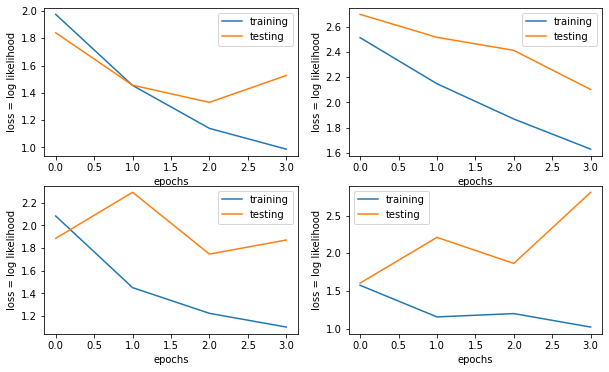

In [30]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,6))
plt.subplot(221)
plt.plot(epoch, loss_train_fold4_pancreas, label = 'training')
plt.plot(epoch, loss_val_fold4_pancreas, label = 'testing')
plt.ylabel('loss = log likelihood')
plt.xlabel('epochs')
plt.legend()

plt.subplot(222)
plt.plot(epoch, loss_train_fold1_pancreas, label = 'training')
plt.plot(epoch, loss_val_fold1_pancreas, label = 'testing')
plt.ylabel('loss = log likelihood')
plt.xlabel('epochs')
plt.legend()



plt.subplot(223)
plt.plot(epoch, loss_train_fold2_pancreas, label = 'training')
plt.plot(epoch, loss_val_fold2_pancreas, label = 'testing')
plt.ylabel('loss = log likelihood')
plt.xlabel('epochs')
plt.legend()

plt.subplot(224)
plt.plot(epoch, loss_train_fold3_pancreas, label = 'training')
plt.plot(epoch, loss_val_fold3_pancreas, label = 'testing')
plt.ylabel('loss = log likelihood')
plt.xlabel('epochs')
plt.legend()



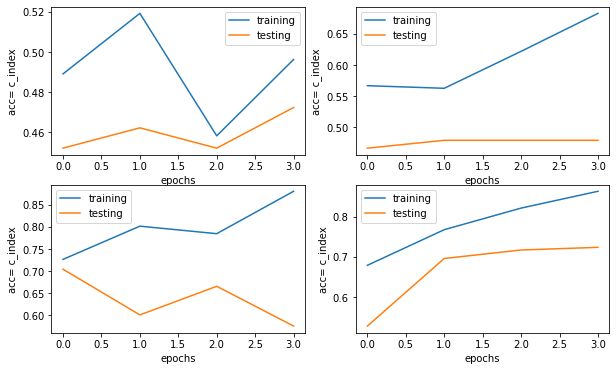

In [31]:
plt.figure(figsize=(10,6))
plt.subplot(221)
plt.plot(epoch, c_index_train_fold0_pancreas, label = 'training')
plt.plot(epoch, c_index_val_fold0_pancreas, label = 'testing')
plt.ylabel('acc= c_index')
plt.xlabel('epochs')
plt.legend()

plt.subplot(222)
plt.plot(epoch, c_index_train_fold1_pancreas, label = 'training')
plt.plot(epoch, c_index_val_fold1_pancreas, label = 'testing')
plt.ylabel('acc= c_index')
plt.xlabel('epochs')
plt.legend()

plt.subplot(223)
plt.plot(epoch, c_index_train_fold3_pancreas, label = 'training')
plt.plot(epoch, c_index_val_fold3_pancreas, label = 'testing')
plt.ylabel('acc= c_index')
plt.xlabel('epochs')
plt.legend()

plt.subplot(224)
plt.plot(epoch, c_index_train_fold4_pancreas, label = 'training')
plt.plot(epoch, c_index_val_fold4_pancreas, label = 'testing')
plt.ylabel('acc= c_index')
plt.xlabel('epochs')
plt.legend()


In [32]:
print(np.mean([c_index_val_fold0_pancreas[1],c_index_val_fold1_pancreas[1],c_index_val_fold2_pancreas[1],c_index_val_fold3_pancreas[1],c_index_val_fold4_pancreas[1]]))

0.5366361796855926
